In [1]:
# Import essential libraries
import pandas as pd, numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
# Load the dataset
df = pd.read_csv("E:/Unified_Mentor_Internship_Data_Analyst_Projects/Customer Satisfaction Analysis Project/customer_support_tickets.csv")

In [3]:
print(df.head(5))

   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       2021-03-22  Technical issue   
1          Female       LG Smart TV       2021-05-22  Technical issue   
2           Other          Dell XPS       2020-07-14  Technical issue   
3          Female  Microsoft Office       2020-11-13  Billing inquiry   
4          Female  Autodesk AutoCAD       2020-02-04  Billing inquiry   

             Ticket Subject  \
0             Product setup   
1  Peripheral compatibil

In [4]:
print("Shape:", df.shape)

Shape: (8469, 17)


In [5]:
df.describe()

,Ticket ID,Customer Age,Customer Satisfaction Rating
count,8469.000000,8469.000000,2769.000000
mean,4235.000000,44.026804,2.991333
std,2444.934048,15.296112,1.407016
min,1.000000,18.000000,1.000000
25%,2118.000000,31.000000,2.000000
50%,4235.000000,44.000000,3.000000
75%,6352.000000,57.000000,4.000000
max,8469.000000,70.000000,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [7]:
print("Columns:", df.columns.tolist())


Columns: ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']


In [8]:
df.isnull().sum()

Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

In [9]:
# Data Preprocessing & Feature Engineering
# Filter for closed tickets
closed_tickets = df[df["Ticket Status"] == "Closed"].copy()

In [10]:
closed_tickets.reset_index(drop=True, inplace=True)
data = closed_tickets

In [11]:
data.isnull().sum()

Ticket ID                       0
Customer Name                   0
Customer Email                  0
Customer Age                    0
Customer Gender                 0
Product Purchased               0
Date of Purchase                0
Ticket Type                     0
Ticket Subject                  0
Ticket Description              0
Ticket Status                   0
Resolution                      0
Ticket Priority                 0
Ticket Channel                  0
First Response Time             0
Time to Resolution              0
Customer Satisfaction Rating    0
dtype: int64

In [12]:
# Convert columns to datetime
data["First Response Time"] = pd.to_datetime(data["First Response Time"], errors="coerce")
data["Time to Resolution"] = pd.to_datetime(data["Time to Resolution"], errors="coerce")

In [13]:
# Identify invalid rows
invalid_rows = data[data["Time to Resolution"] < data["First Response Time"]]

# Output results
print("Invalid rows where resolution is before response:")
print(invalid_rows.tail(5))

Invalid rows where resolution is before response:
      Ticket ID     Customer Name              Customer Email  Customer Age  \
2764       8453      Craig Forbes       jessica60@example.org            62   
2765       8454     Paula Vazquez       wanderson@example.com            61   
2766       8456         Ariel Lee  thompsonsamuel@example.org            54   
2767       8467   Michelle Kelley        ashley83@example.org            57   
2768       8468  Steven Rodriguez         fpowell@example.org            54   

     Customer Gender     Product Purchased Date of Purchase      Ticket Type  \
2764          Female           MacBook Pro       2020-03-29   Refund request   
2765           Other                iPhone       2020-06-20  Billing inquiry   
2766           Other  Dyson Vacuum Cleaner       2021-02-02  Billing inquiry   
2767          Female   GoPro Action Camera       2021-08-17  Technical issue   
2768            Male           PlayStation       2021-10-16  Product inquir

In [14]:
# Fix by swapping dates (if you suspect they were reversed)
data.loc[data["Time to Resolution"] < data["First Response Time"], ["First Response Time", "Time to Resolution"]] = \
    data.loc[data["Time to Resolution"] < data["First Response Time"], ["Time to Resolution", "First Response Time"]].values

In [15]:
# Calculate resolution time in hours
Resolution_Time_Hours = (
    (data["Time to Resolution"] - data["First Response Time"]).dt.total_seconds() / 3600
).apply(lambda x: x if x >= 0 else np.nan
)
# Compute average
data["Average Resolution Time"] = Resolution_Time_Hours.mean()
print("Average Resolution Time (Hours):", data["Average Resolution Time"])

Average Resolution Time (Hours): 0       7.742368
1       7.742368
2       7.742368
3       7.742368
4       7.742368
          ...   
2764    7.742368
2765    7.742368
2766    7.742368
2767    7.742368
2768    7.742368
Name: Average Resolution Time, Length: 2769, dtype: float64


In [16]:
# Convert date to days since purchase
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], errors='coerce')
data['Days Since Purchase'] = (pd.to_datetime('today') - data['Date of Purchase']).dt.days

In [17]:
# Drop unused datetime columns
data = data.drop(columns=["Ticket Status", "First Response Time", "Time to Resolution", "Date of Purchase"])

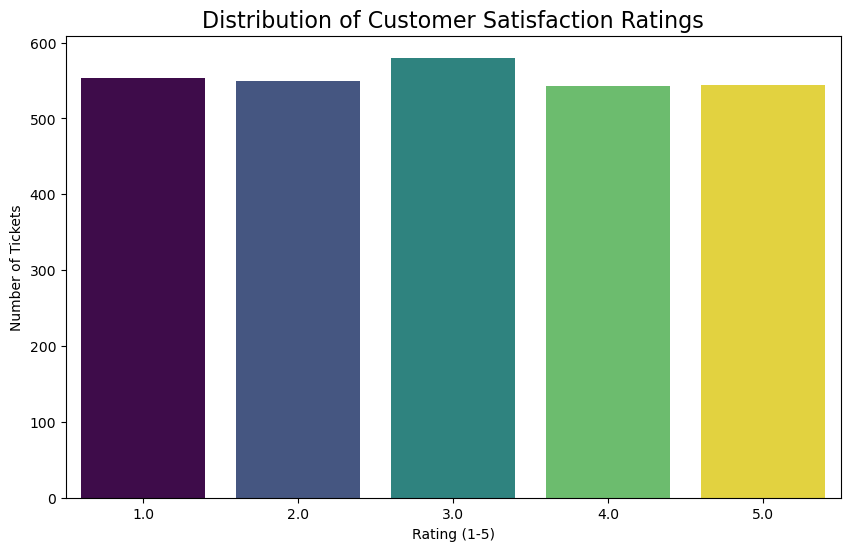

In [18]:
#Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(x='Customer Satisfaction Rating', hue='Customer Satisfaction Rating', data=data, palette='viridis', legend=False)
plt.title('Distribution of Customer Satisfaction Ratings', fontsize=16)
plt.xlabel('Rating (1-5)')
plt.ylabel('Number of Tickets')
plt.show()

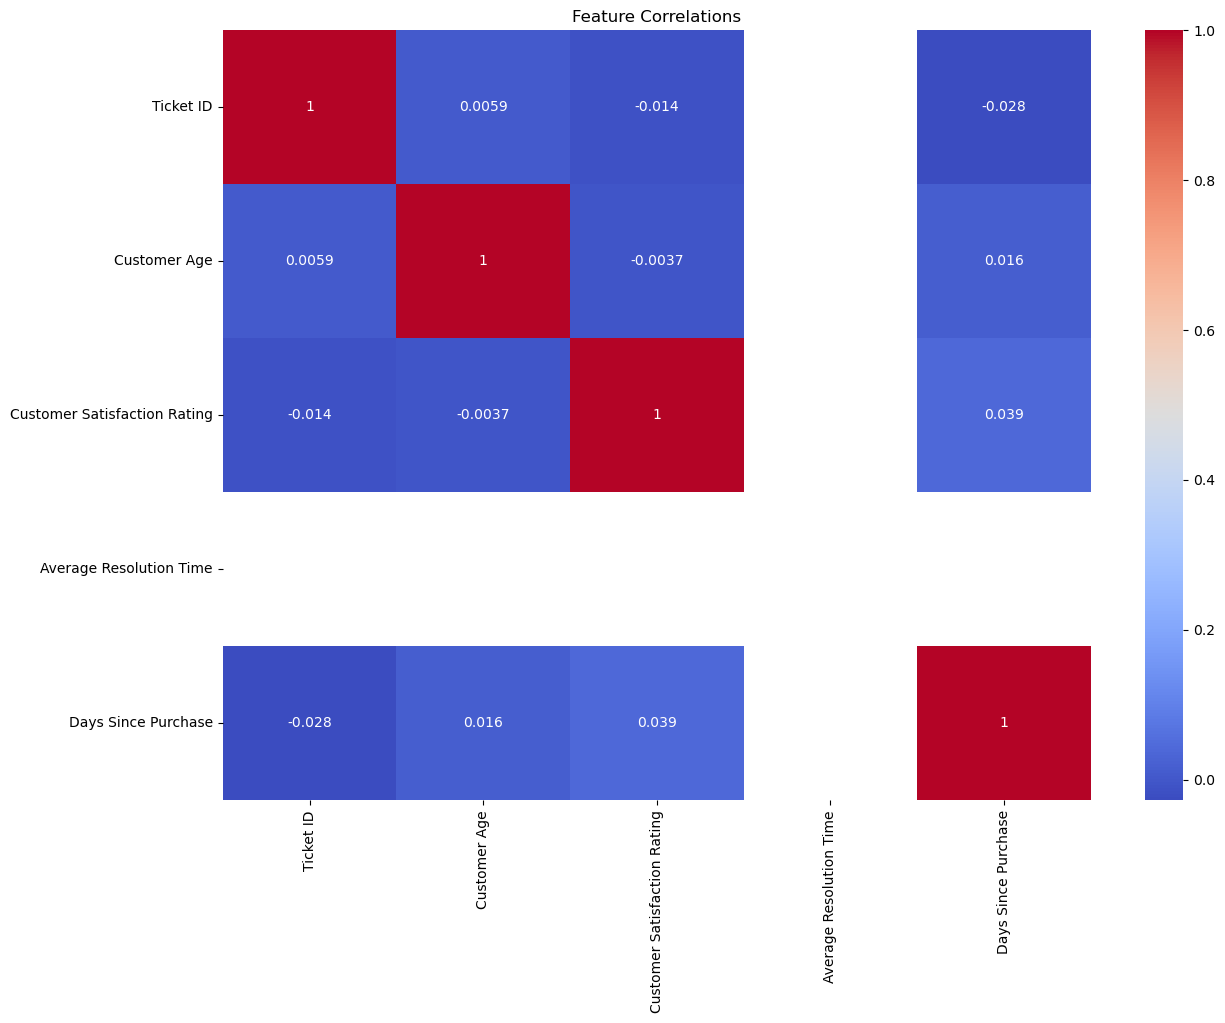

In [19]:
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

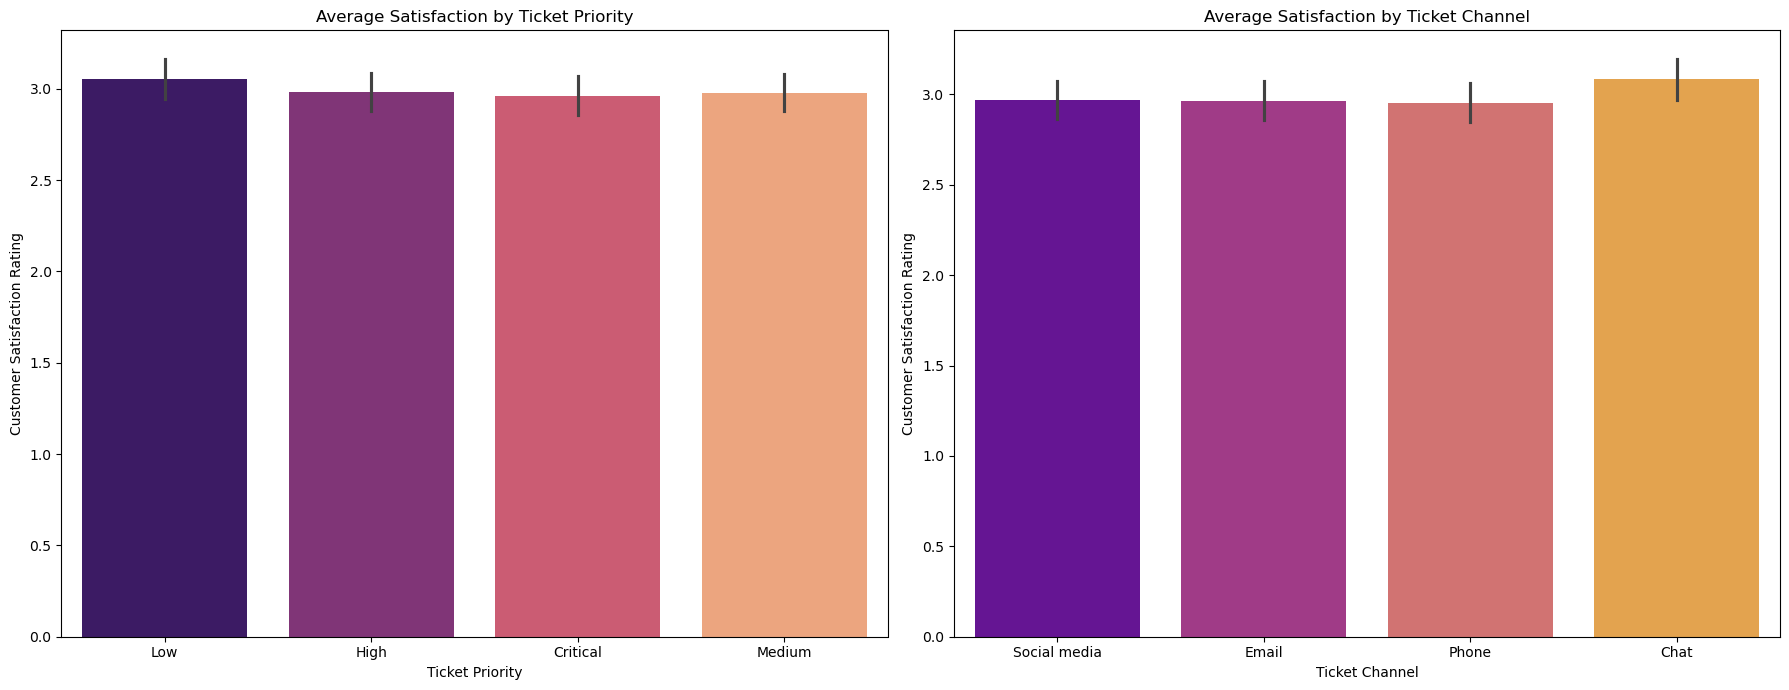

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Satisfaction by Ticket Priority
sns.barplot(
    x='Ticket Priority', 
    y='Customer Satisfaction Rating', 
    hue='Ticket Priority', 
    data=data, 
    ax=axes[0], 
    palette='magma', 
    legend=False
)
axes[0].set_title('Average Satisfaction by Ticket Priority')

# Satisfaction by Ticket Channel
sns.barplot(
    x='Ticket Channel', 
    y='Customer Satisfaction Rating', 
    hue='Ticket Channel', 
    data=data, 
    ax=axes[1], 
    palette='plasma', 
    legend=False
)
axes[1].set_title('Average Satisfaction by Ticket Channel')

plt.tight_layout()
plt.show()


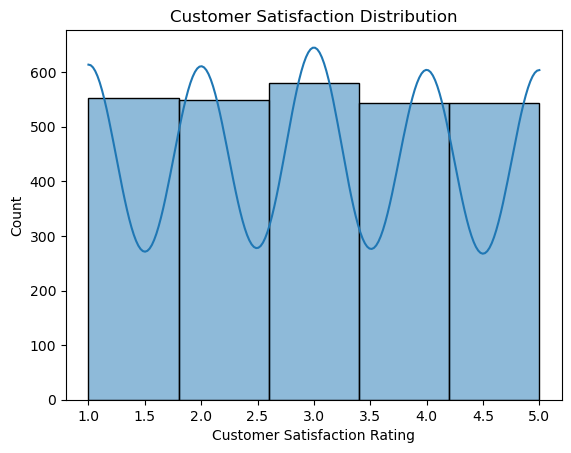

In [21]:
# Satisfaction distribution
sns.histplot(data['Customer Satisfaction Rating'], bins=5, kde=True)
plt.title('Customer Satisfaction Distribution')
plt.show()

In [22]:
# Encode categorical columns
categorical_cols = ["Customer Gender", "Product Purchased",
                    "Ticket Type", "Ticket Priority", "Ticket Channel"]

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))


In [23]:
# Prepare features and target
X = X = data[[
    "Customer Age", "Customer Gender", "Product Purchased",
    "Ticket Type", "Ticket Priority", "Ticket Channel",
    "Average Resolution Time", "Days Since Purchase" 
]]
y = data["Customer Satisfaction Rating"]
y = (y >= 4).astype(int)  # Satisfied: 4-5, Unsatisfied: 1-3


In [24]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# Balance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [26]:
# Modeling
categorical_cols = ["Customer Gender", "Product Purchased", "Ticket Type", "Ticket Priority", "Ticket Channel"]
numeric_cols = ["Customer Age", "Average Resolution Time", "Days Since Purchase"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

In [27]:
# Logistic Regression pipeline
pipe_log = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(solver="liblinear", max_iter=200, random_state=42, class_weight="balanced"))
])
pipe_log.fit(X_train, y_train)
y_pred_log = pipe_log.predict(X_test)

In [28]:
# Random Forest pipeline
pipe_rf = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"))
])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

In [29]:
# Evaluation
# ----------------------------
print("\n--- Logistic Regression Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, digits=3))

print("\n--- Random Forest Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))


--- Logistic Regression Evaluation ---
Accuracy: 0.5667870036101083
              precision    recall  f1-score   support

           0      0.655     0.608     0.631       337
           1      0.452     0.502     0.476       217

    accuracy                          0.567       554
   macro avg      0.554     0.555     0.553       554
weighted avg      0.576     0.567     0.570       554


--- Random Forest Evaluation ---
Accuracy: 0.5794223826714802
              precision    recall  f1-score   support

           0      0.652     0.662     0.657       337
           1      0.462     0.452     0.457       217

    accuracy                          0.579       554
   macro avg      0.557     0.557     0.557       554
weighted avg      0.578     0.579     0.579       554



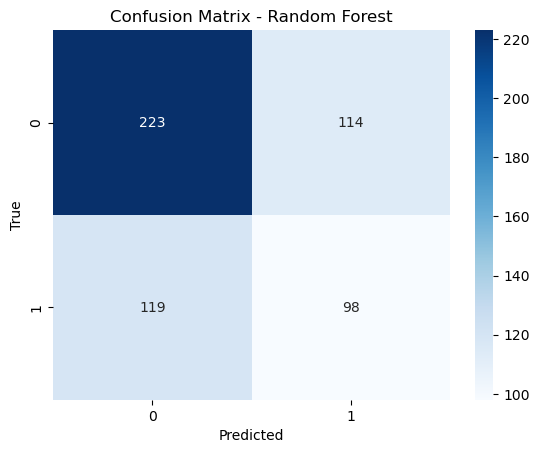

In [30]:
# Confusion matrix (Random Forest)
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [31]:
with open("customer_satisfaction_pipeline.pkl", "wb") as f:
    pickle.dump(pipe_rf, f)

In [32]:
# Predict New 
# Load pipeline
with open("customer_satisfaction_pipeline.pkl", "rb") as f:
    model = pickle.load(f)

new_data = pd.DataFrame([{
    "Customer Age": 32,
    "Customer Gender": "Female",
    "Product Purchased": "LG Smart TV",
    "Ticket Type": "Technical Issue",
    "Ticket Priority": "Critical",
    "Ticket Channel": "Chat",
    "Average Resolution Time" : 2,
    "Days Since Purchase": 24
}])

prediction = model.predict(new_data)
print("\nPredicted Satisfaction (1=Happy, 0=Unhappy):", prediction[0])



Predicted Satisfaction (1=Happy, 0=Unhappy): 1


**SQL**


In [33]:
import pandas as pd
import duckdb

# Register with DuckDB
duckdb.register("data", df)

In [34]:
#Average Satisfaction by Ticket Type
q1 = duckdb.sql("""
SELECT 
    "Ticket Type",
    ROUND(AVG("Customer Satisfaction Rating"),2) AS Avg_Satisfaction
FROM data
GROUP BY "Ticket Type"
ORDER BY Avg_Satisfaction DESC;
""").df()

print(q1)

            Ticket Type  Avg_Satisfaction
0       Billing inquiry              3.03
1  Cancellation request              3.03
2       Product inquiry              3.02
3       Technical issue              2.96
4        Refund request              2.93


In [35]:
#Average Satisfaction and Total Tickets by Ticket Type
q2 = duckdb.sql("""SELECT 
    "Ticket Priority",
    COUNT(*) AS Total_Tickets,
    ROUND(AVG("Customer Satisfaction Rating"),2) AS Avg_Satisfaction
FROM data
GROUP BY "Ticket Priority"
ORDER BY Avg_Satisfaction DESC;
""").df()
print(q2)

  Ticket Priority  Total_Tickets  Avg_Satisfaction
0             Low           2063              3.05
1          Medium           2192              2.98
2            High           2085              2.98
3        Critical           2129              2.96


In [36]:
q4 = duckdb.sql("""SELECT 
    "Ticket Channel",
    COUNT(*) AS Total_Tickets,
    ROUND(AVG("Customer Satisfaction Rating"),2) AS Avg_Satisfaction
FROM data
GROUP BY "Ticket Channel"
ORDER BY Avg_Satisfaction DESC;
""").df()
print(q4)

  Ticket Channel  Total_Tickets  Avg_Satisfaction
0           Chat           2073              3.08
1   Social media           2121              2.97
2          Email           2143              2.96
3          Phone           2132              2.95


In [37]:
#Top Products by Satisfaction
q5 = duckdb.sql("""SELECT 
    "Product Purchased",
    COUNT(*) AS Tickets,
    ROUND(AVG("Customer Satisfaction Rating"),2) AS Avg_Satisfaction
FROM data
GROUP BY "Product Purchased"
ORDER BY Avg_Satisfaction DESC
LIMIT 5;
""").df()
print(q5)

      Product Purchased  Tickets  Avg_Satisfaction
0          Google Pixel      203              3.22
1  Dyson Vacuum Cleaner      198              3.22
2     Garmin Forerunner      208              3.21
3      Autodesk AutoCAD      196              3.20
4              Asus ROG      187              3.20


In [38]:
#Customer Segment Analysis (Age Groups)
q6 = duckdb.sql("""SELECT 
    CASE 
        WHEN "Customer Age" < 25 THEN '18-24'
        WHEN "Customer Age" BETWEEN 25 AND 40 THEN '25-40'
        WHEN "Customer Age" BETWEEN 41 AND 60 THEN '41-60'
        ELSE '60+' 
    END AS Age_Group,
    COUNT(*) AS Tickets,
    ROUND(AVG("Customer Satisfaction Rating"),2) AS Avg_Satisfaction
FROM data
GROUP BY Age_Group
ORDER BY Avg_Satisfaction DESC;
""").df()
print(q6)

  Age_Group  Tickets  Avg_Satisfaction
0     25-40     2494              3.03
1       60+     1570              3.00
2     41-60     3267              2.97
3     18-24     1138              2.95
